In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
results_path = "../reports"

model_list = ["UNet++", "AttentionUNet", "UNet", "VNet", "NoSkipUNet", "NoSkipVNet"]
anatomy_list = ["BUSI", "GLaS", "Heart", "Spleen"]
variant_list = ["lower", "low", "in-domain", "high", "higher"]

For texture variant: lower mean scores;
          UNet++ AttentionUNet      UNet      VNet NoSkipUNet NoSkipVNet
BUSI    0.111771      0.429491  0.466379  0.651097   0.527407    0.69158
GLaS    0.506245      0.498473  0.502812  0.579106   0.516754   0.557915
Heart   0.000884      0.041415  0.194341   0.89884   0.893547   0.964293
Spleen       0.0      0.245259  0.055807  0.001217   0.448371   0.293494
For texture variant: lower std scores;
          UNet++ AttentionUNet      UNet      VNet NoSkipUNet NoSkipVNet
BUSI    0.121792      0.279095   0.30949  0.317012   0.311961   0.235805
GLaS    0.150991      0.171137  0.155028  0.175598   0.156983   0.170483
Heart   0.012447      0.071664  0.238301  0.124433   0.128751   0.067926
Spleen       0.0      0.218394  0.130819  0.019486   0.281995   0.255142
For texture variant: low mean scores;
          UNet++ AttentionUNet      UNet      VNet NoSkipUNet NoSkipVNet
BUSI    0.146143      0.512486  0.560314   0.66896   0.555261   0.696028
GLaS   

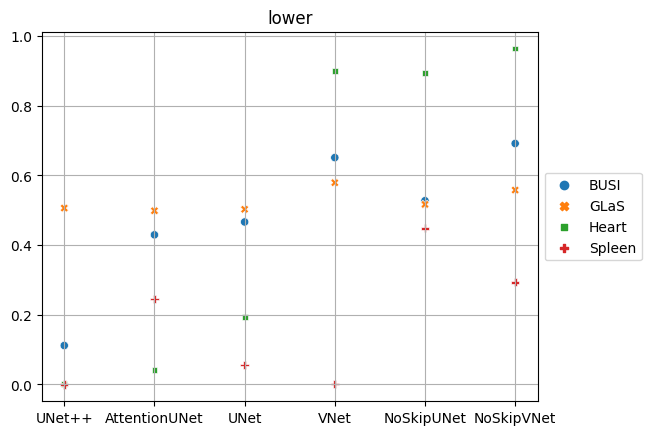

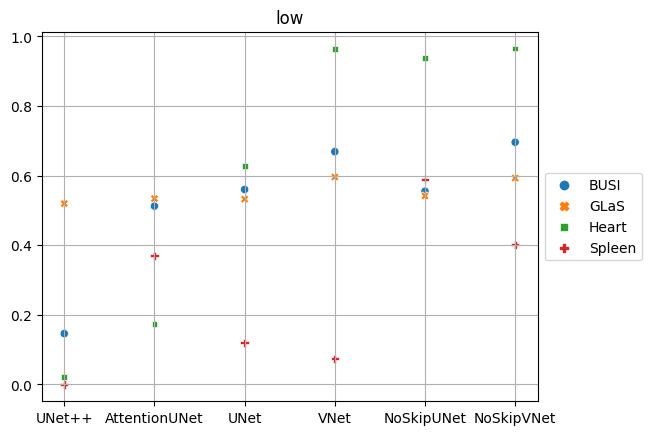

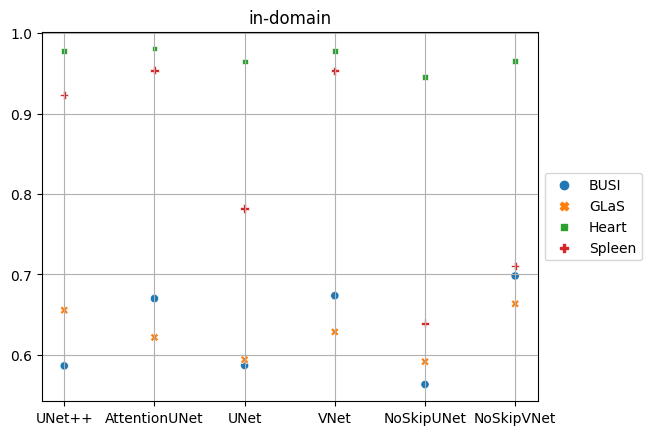

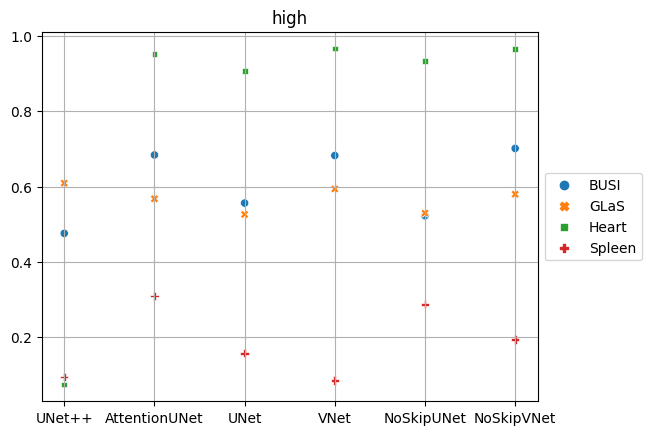

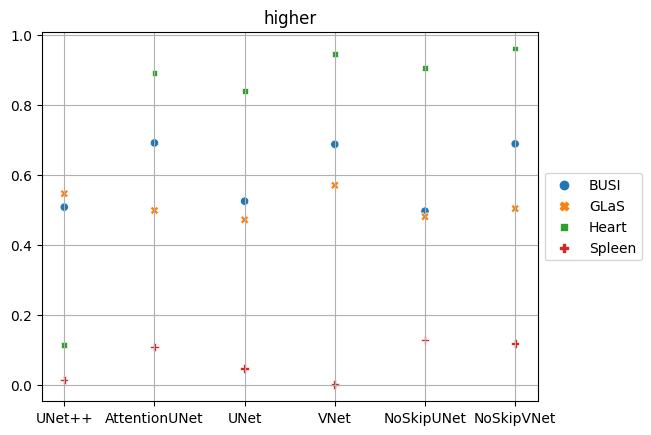

<Figure size 640x480 with 0 Axes>

In [3]:
sdsc_mean_data = {}
sdsc_std_data = {}

for texture_variant in ["lower", "low", "in-domain", "high", "higher"]:
    sdsc_mean = pd.DataFrame(columns=model_list,
                    index=anatomy_list)

    sdsc_sd = pd.DataFrame(columns=model_list,
                    index=anatomy_list)

    for anatomy in anatomy_list:
        for model_name in model_list:
            result_seed_1 = os.path.join(results_path, anatomy + "-results", anatomy + "_stats_" + model_name + "_" + texture_variant + "_256_1.csv")
            result_seed_2 = os.path.join(results_path, anatomy + "-results", anatomy + "_stats_" + model_name + "_" + texture_variant + "_256_2.csv")
            result_seed_3 = os.path.join(results_path, anatomy + "-results", anatomy + "_stats_" + model_name + "_" + texture_variant + "_256_3.csv")

            seed_1_data = pd.read_csv(result_seed_1)
            seed_1_data = seed_1_data.loc[seed_1_data['Set'] == "test"]

            seed_2_data = pd.read_csv(result_seed_2)
            seed_2_data = seed_2_data.loc[seed_2_data['Set'] == "test"]

            seed_3_data = pd.read_csv(result_seed_3)
            seed_3_data = seed_3_data.loc[seed_3_data['Set'] == "test"]

            sdsc_scores = np.hstack((seed_1_data["SurfaceDSC"].to_numpy(), seed_2_data["SurfaceDSC"].to_numpy(), seed_3_data["SurfaceDSC"].to_numpy()))
            sdsc_scores[~np.isfinite(sdsc_scores)] = np.sqrt(2) * 256

            #print("For anatomy: " + anatomy + " and model: " + model_name + " and texture: " + texture_variant + ", sdsc mean: " + str(np.nanmean(sdsc_scores)) + ", std: " + str(np.nanstd(sdsc_scores)))

            sdsc_mean[model_name][anatomy] = np.mean(sdsc_scores)
            sdsc_sd[model_name][anatomy] = np.std(sdsc_scores)
    
    sdsc_mean_data[texture_variant] = sdsc_mean
    sdsc_std_data[texture_variant] = sdsc_sd
    
    print("For texture variant: " + str(texture_variant) + " mean scores;")
    print(sdsc_mean)
    print("For texture variant: " + str(texture_variant) + " std scores;")
    print(sdsc_sd)
    ax = sns.scatterplot(data=sdsc_mean.T)
    ax.set_title(str(texture_variant))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.figure()


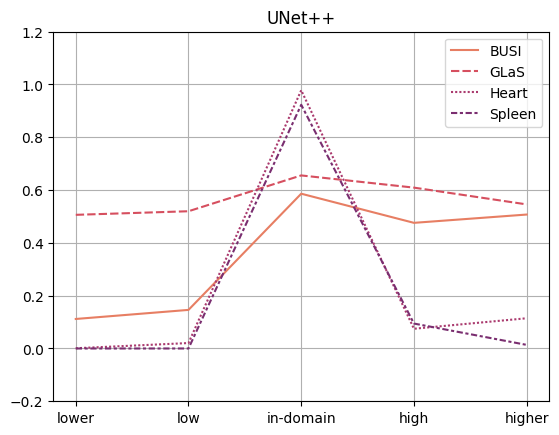

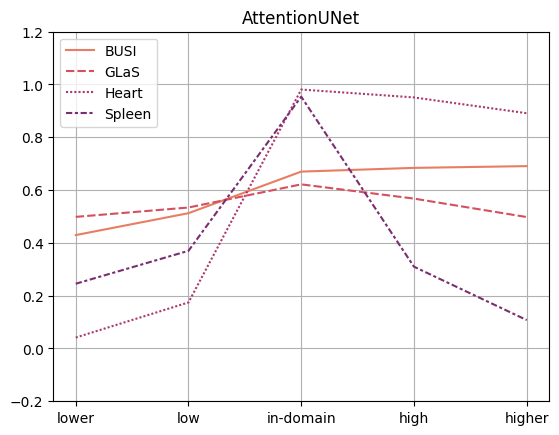

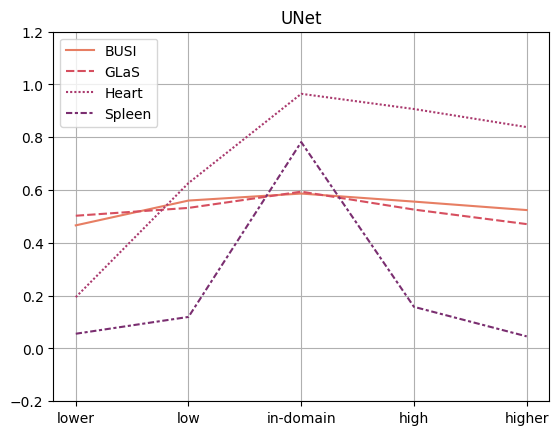

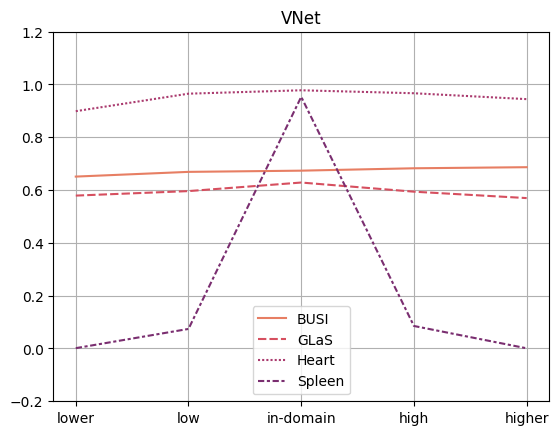

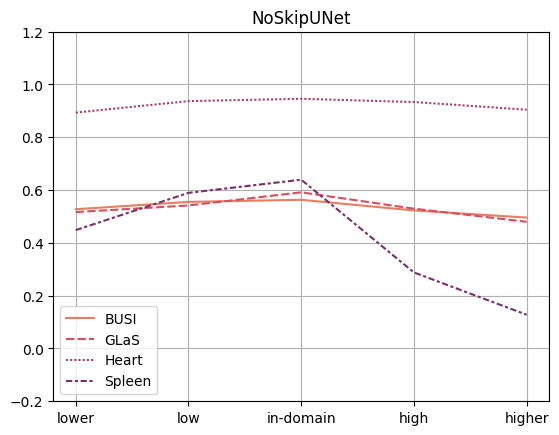

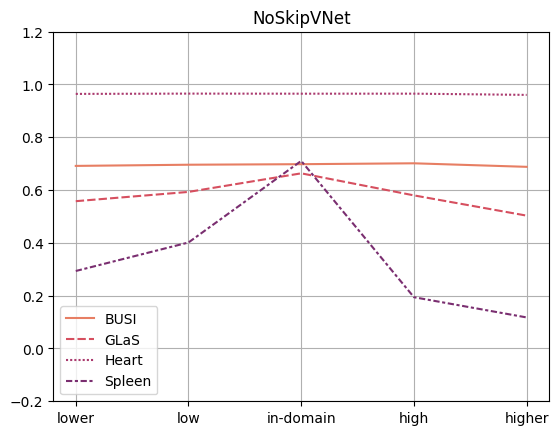

In [4]:
for model_type in model_list:
    results_by_image = {}
    for image_type in anatomy_list:
        mean_line = []
        for variant in variant_list:
            mean_line.append(sdsc_mean_data[variant][model_type][image_type])

        results_by_image[image_type] = mean_line

    plt.figure()
    df = pd.DataFrame.from_dict(results_by_image, columns=variant_list, orient='index')
    sns.lineplot(data=df.T, palette='flare')
    plt.title(model_type)
    plt.grid(True)
    plt.ylim([-0.2, 1.2])

/var/folders/yr/q_0gpqgs1lq_rtbttpk3n9bh0000gn/T/ipykernel_10924/2544048259.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


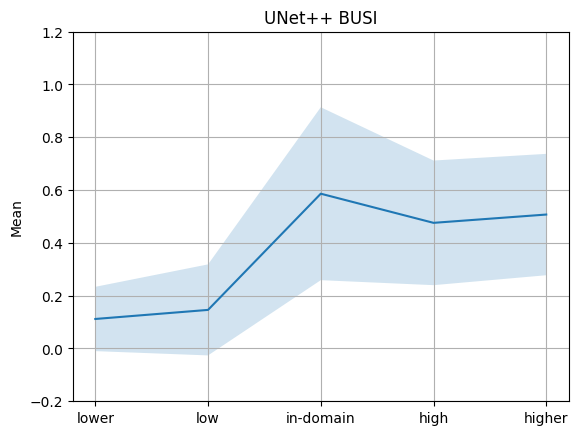

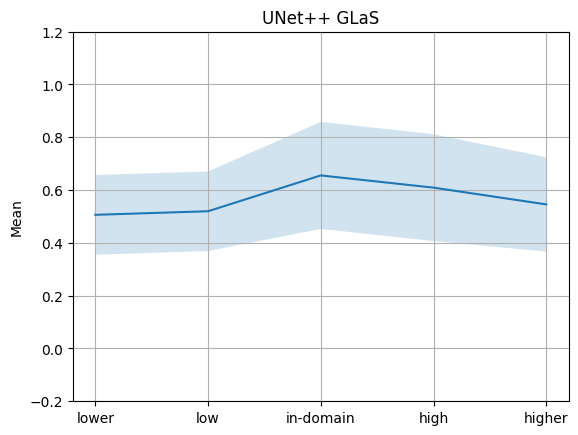

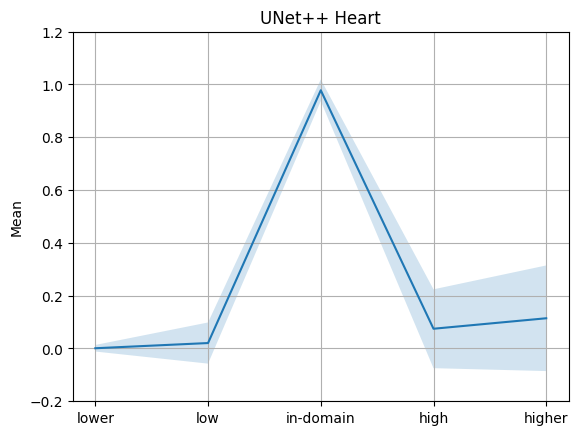

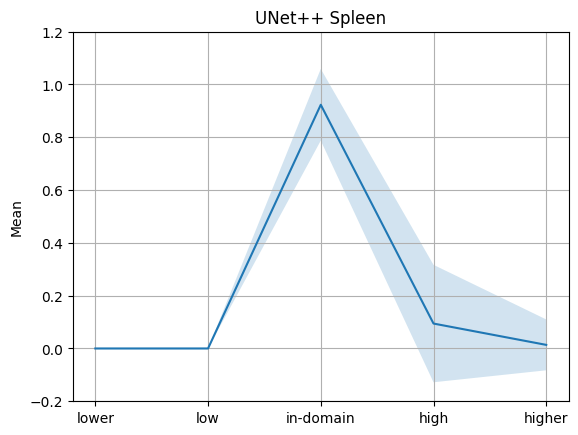

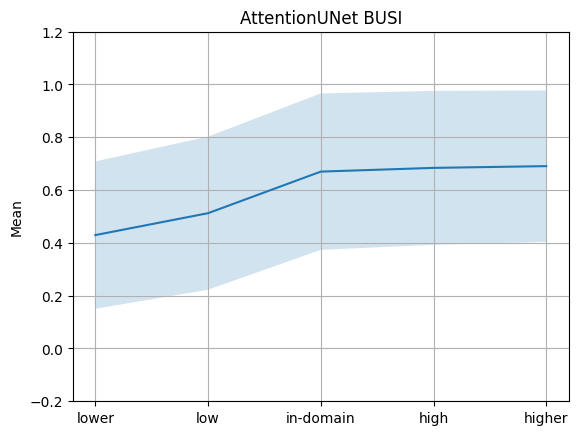

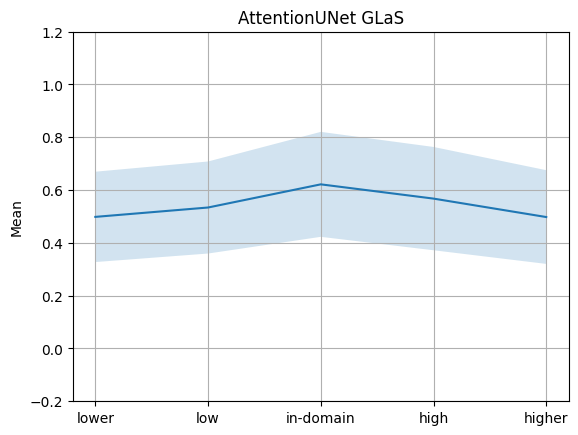

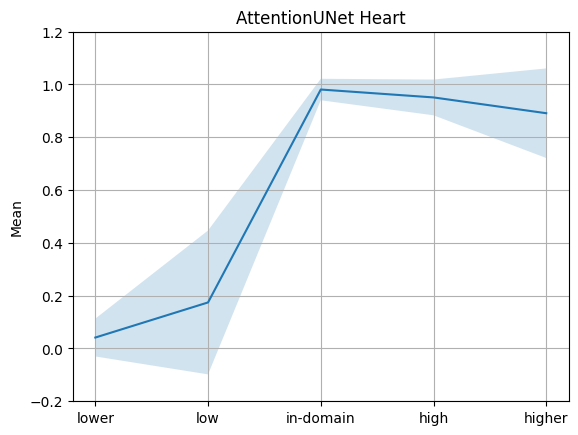

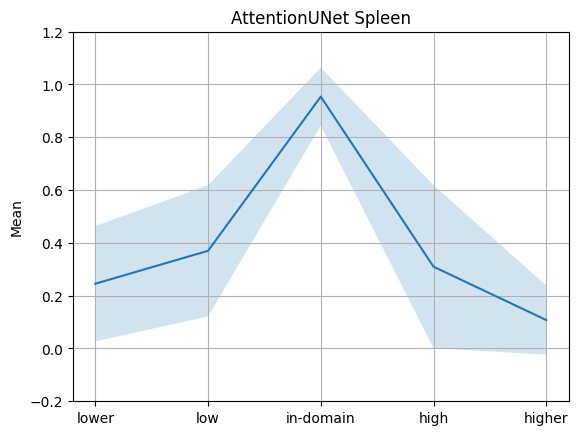

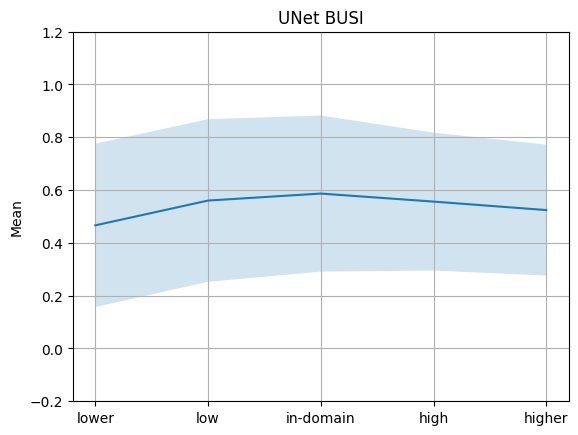

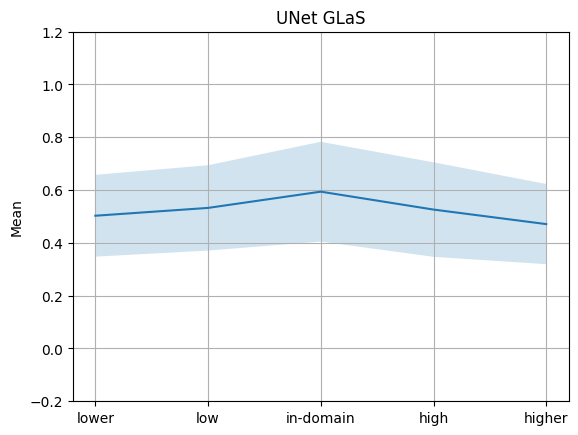

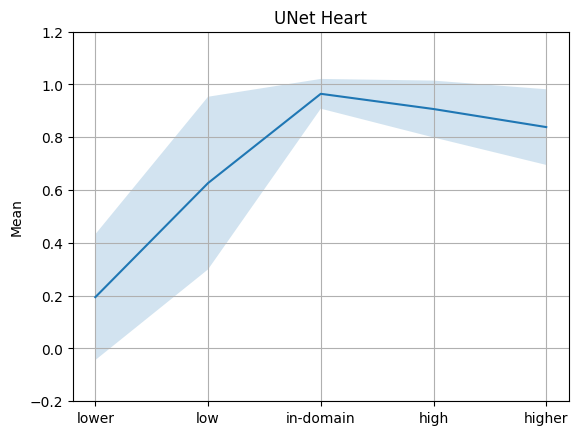

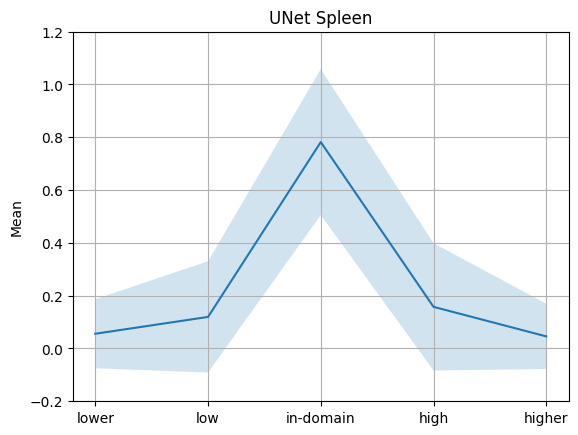

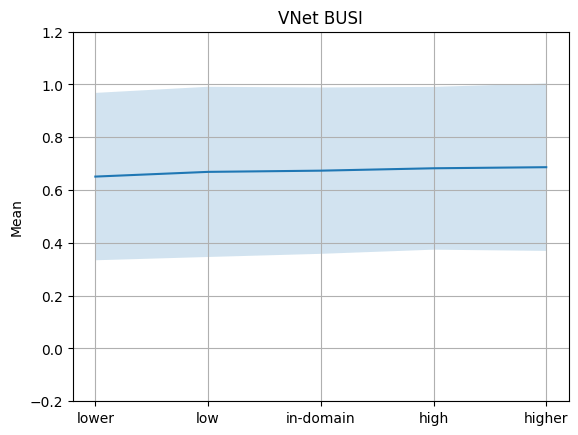

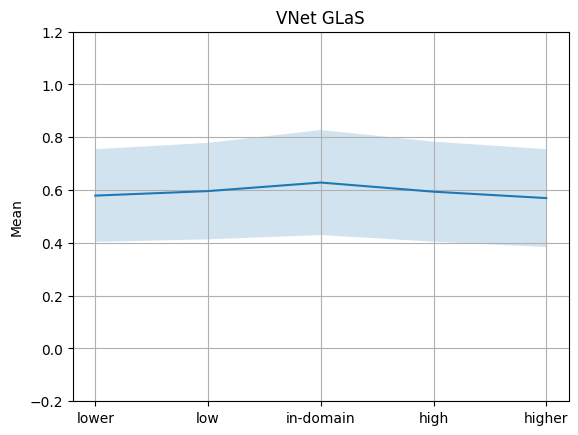

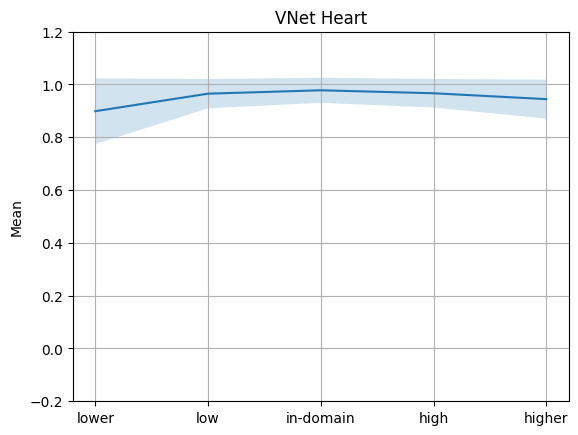

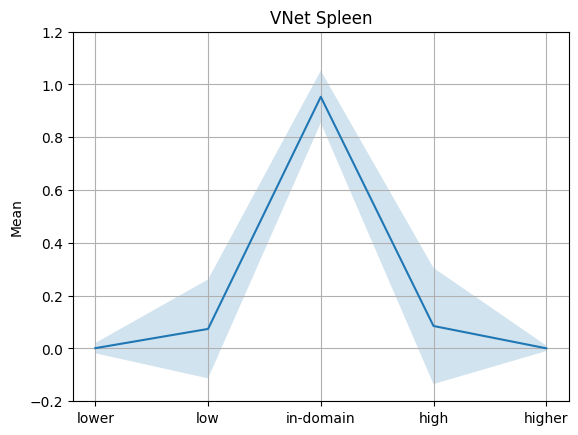

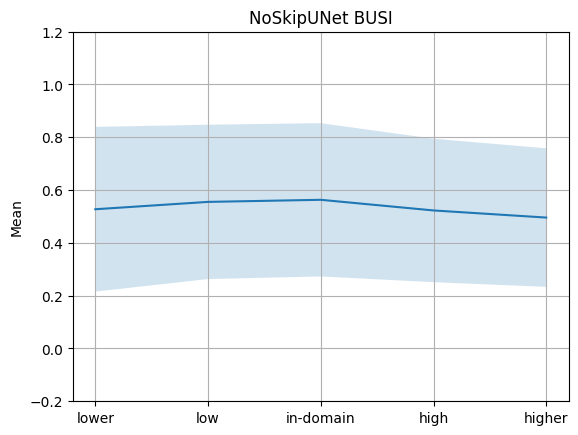

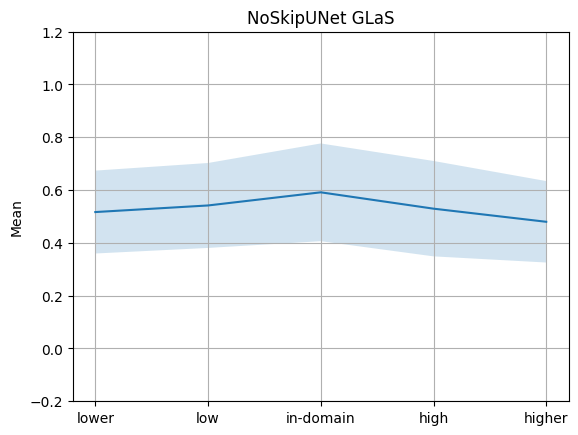

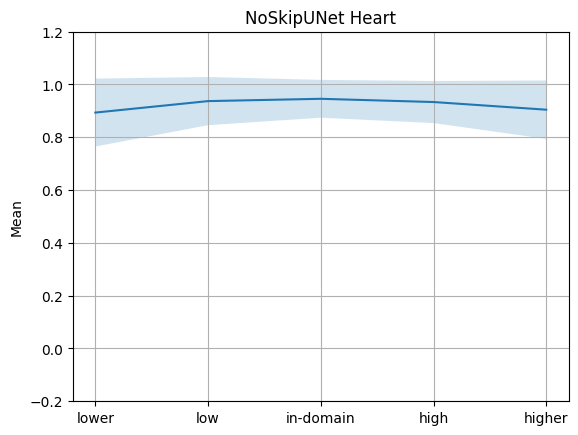

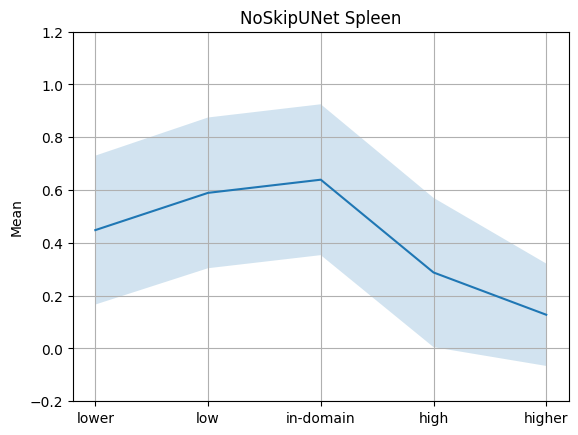

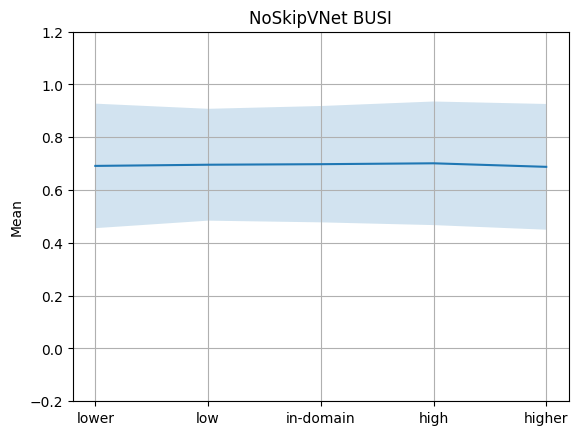

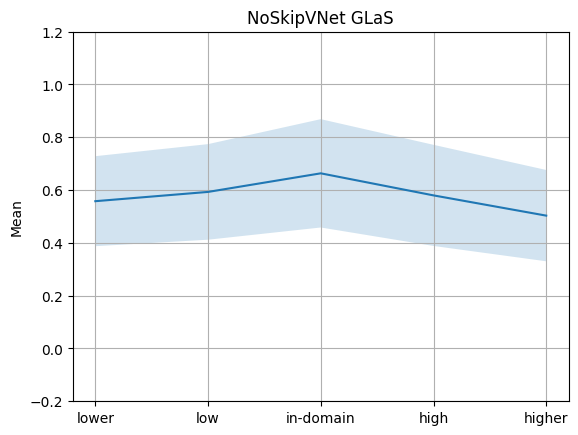

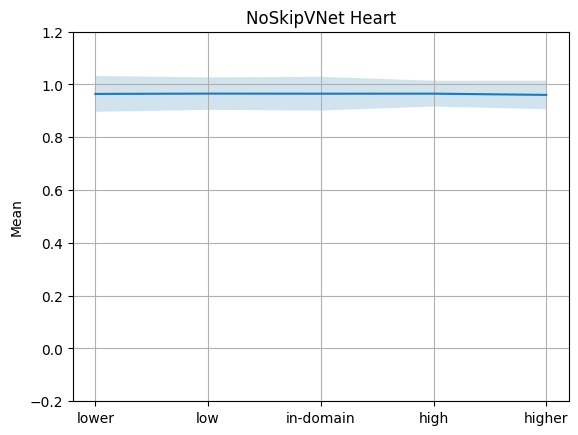

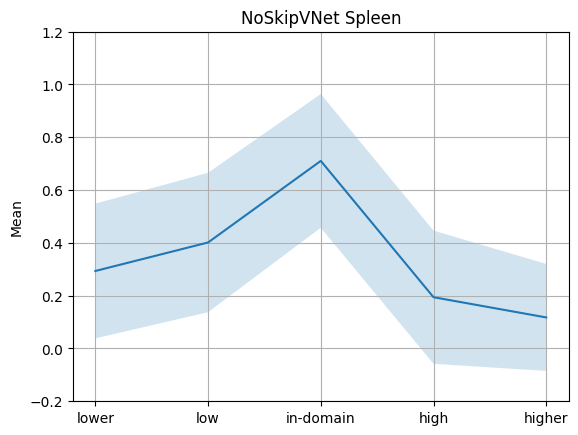

In [5]:
for model_type in model_list:
    for image_type in anatomy_list:
        results_by_image = {}
        mean_line = []
        std_lower = []
        std_higher = []
        for variant in variant_list:
            mean_line.append(sdsc_mean_data[variant][model_type][image_type])
            std_lower.append(sdsc_mean_data[variant][model_type][image_type] - sdsc_std_data[variant][model_type][image_type])
            std_higher.append(sdsc_mean_data[variant][model_type][image_type] + sdsc_std_data[variant][model_type][image_type])

        results_by_image["Mean"] = mean_line
        results_by_image["Lower"] = std_lower
        results_by_image["Higher"] = std_higher

        plt.figure()
        df = pd.DataFrame.from_dict(results_by_image, columns=variant_list, orient='index')
        ax = sns.lineplot(data=df.T, x=df.T.index, y="Mean", palette='flare')
        ax.fill_between(df.T.index, df.T.Lower, df.T.Higher, alpha=0.2)
        plt.title(model_type + " " + image_type)
        plt.grid(True)
        plt.ylim([-0.2, 1.2])